# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [53]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation


from collections import Counter, defaultdict



In [2]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [7]:
import nltk
nltk.download('brown')


# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


[nltk_data] Downloading package brown to
[nltk_data]     /Users/sadafvaziri/nltk_data...
[nltk_data]   Package brown is already up-to-date!


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [8]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [9]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


/Users/sadafvaziri/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backends is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/sadafvaziri/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/sadafvaziri/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/sadafvaziri/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Axes: xlabel='category'>

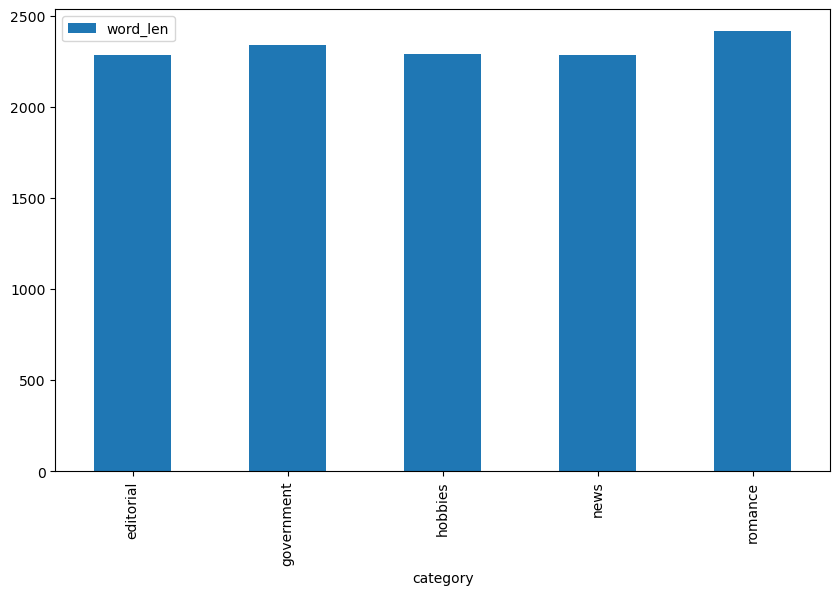

In [10]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [22]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

stop_words = stopwords.words('english')

count_text_vectorizer = CountVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sadafvaziri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(166, 5073)

In [26]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

stop_words = stopwords.words('english')

# TF-IDF vectorization
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape





[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sadafvaziri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(166, 5073)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: count text vectors holds the raw word frequency counts for each word (feature) in each document.tfidf holds the TF-IDF (Term Frequency-Inverse Document Frequency) scores, which weigh word importance by how common or rare a term is across the entire corpus.

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [29]:
from sklearn.decomposition import NMF


nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_


In [30]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.48)
  president (0.43)
  kennedy (0.41)
  united (0.40)
  khrushchev (0.38)

Topic 01
  said (0.78)
  thought (0.38)
  back (0.34)
  man (0.34)
  little (0.31)

Topic 02
  mrs (2.38)
  mr (0.75)
  said (0.71)
  miss (0.48)
  car (0.46)

Topic 03
  state (0.38)
  development (0.35)
  tax (0.32)
  sales (0.29)
  may (0.28)

Topic 04
  game (0.97)
  league (0.70)
  ball (0.69)
  baseball (0.66)
  team (0.63)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


category,editorial,government,hobbies,news,romance
nmf_topic,,,,,
0,21,5,1,8,0
1,5,0,10,0,29
2,0,0,1,18,0
3,1,25,22,9,0
4,0,0,2,9,0


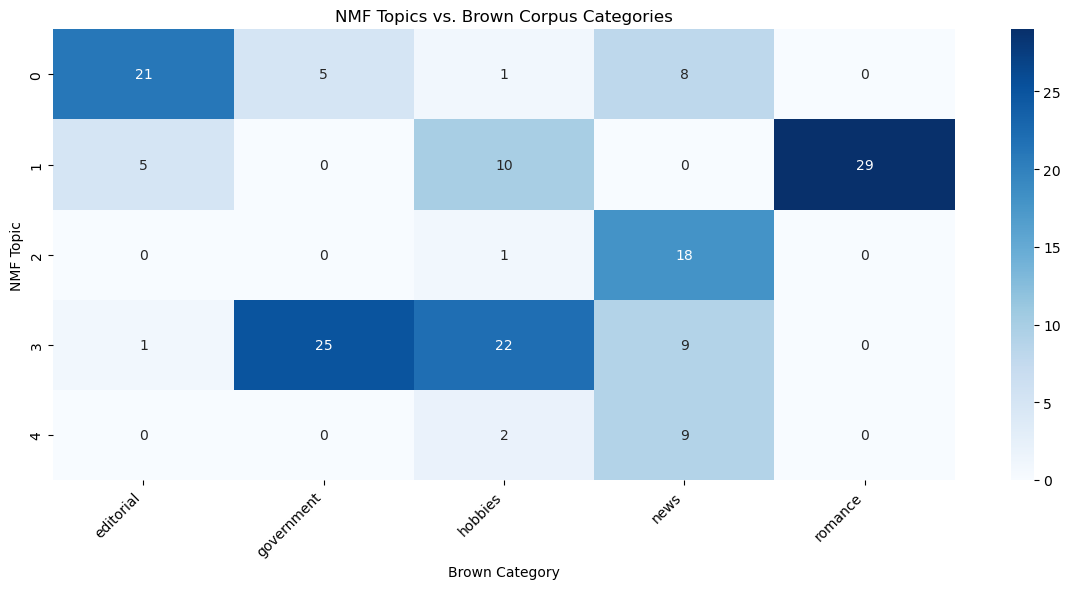

In [31]:
# Your code here

df['nmf_topic'] = np.argmax(W_text_matrix, axis=1)

topic_vs_category = df.groupby(['nmf_topic', 'category']).size().unstack(fill_value=0)
display(topic_vs_category)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(topic_vs_category, annot=True, fmt='d', cmap='Blues')
plt.title('NMF Topics vs. Brown Corpus Categories')
plt.ylabel('NMF Topic')
plt.xlabel('Brown Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()





Q: How does your five-topic NMF model compare to the original Brown categories? 

A: The NMF model shows partial alignment with the original Brown categories. For example, Topic 1 strongly matches the "romance" category, while Topic 2 aligns well with "news." However, other topics like Topic 3 mix documents from "government" and "hobbies," suggesting some overlap in language use across categories. Overall, the model captures meaningful structure but doesn’t fully replicate the original labels.<!-- Your answer here --> 

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sadafvaziri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


category,editorial,government,hobbies,news,romance
lsa_topic,,,,,
0,27,30,36,33,25
1,0,0,0,0,4
2,0,0,0,3,0
3,0,0,0,1,0
4,0,0,0,7,0


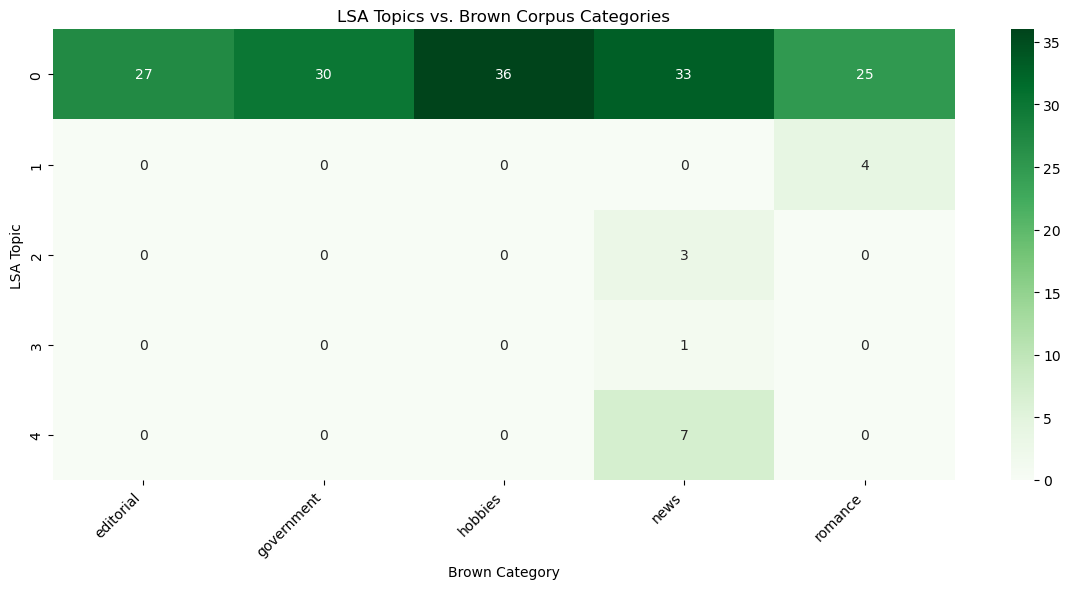

In [32]:

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

stop_words = stopwords.words('english')

# 3. Vectorize text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_vectorizer.fit_transform(df['text'])

# 4. Fit LSA model (Truncated SVD with 5 topics)
lsa_model = TruncatedSVD(n_components=5, random_state=314)
W_lsa_matrix = lsa_model.fit_transform(tfidf_text_vectors)

# 5. Assign most prominent topic to each document
df['lsa_topic'] = np.argmax(W_lsa_matrix, axis=1)

# 6. Create a cross-tabulation of LSA topics vs. Brown categories
lsa_topic_vs_category = df.groupby(['lsa_topic', 'category']).size().unstack(fill_value=0)

# 7. Display the cross-tab (optional, if you're in a notebook)
display(lsa_topic_vs_category)

# 8. Visualize with a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(lsa_topic_vs_category, annot=True, fmt='d', cmap='Greens')
plt.title('LSA Topics vs. Brown Corpus Categories')
plt.ylabel('LSA Topic')
plt.xlabel('Brown Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Q: How does your five-topic LSA model compare to the original Brown categories? 

A:The LSA model heavily concentrated all documents into Topic 0, which includes articles from all categories. This suggests that the model failed to separate the topics meaningfully. Unlike NMF, LSA did not clearly distinguish between categories such as news, romance, or government, indicating weaker topic separation in this case. <!-- Your answer here --> 

In [33]:
# call display_topics on your model

def display_topics(model, feature_names, no_top_words=5):
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        weights = [topic[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        print(f"Topic {topic_idx}:")
        for word, weight in zip(top_features, weights):
            print(f"  {word} ({weight:.2f})")
        print()



display_topics(lsa_model, tfidf_vectorizer.get_feature_names_out())


Topic 0:
  said (0.21)
  mr (0.12)
  mrs (0.10)
  state (0.10)
  man (0.08)

Topic 1:
  said (0.18)
  thought (0.11)
  back (0.09)
  got (0.09)
  looked (0.09)

Topic 2:
  mrs (0.44)
  mr (0.19)
  said (0.14)
  jr (0.09)
  jury (0.08)

Topic 3:
  khrushchev (0.16)
  berlin (0.12)
  soviet (0.12)
  kennedy (0.12)
  laos (0.11)

Topic 4:
  game (0.22)
  league (0.16)
  baseball (0.16)
  ball (0.15)
  team (0.14)



Q: What is your interpretation of the display topics output? 

A: The LSA topics are somewhat diffuse, with recurring words like "said", "mr", and "mrs" appearing across multiple topics, suggesting limited topic distinctiveness. Some topics hint at themes—for example, Topic 3 may relate to international politics ("khrushchev", "berlin", "soviet"), and the last topic (cut off) appears sports-related ("baseball", "ball", "team"). However, overall the topics are not as well-separated as those from the NMF model, indicating weaker interpretability.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sadafvaziri/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Topic 1: game, last, home, clay, three, four, may, good, back, ball

Topic 2: may, service, medical, national, use, area, college, development, program, shelter

Topic 3: much, good, way, used, must, little, brown, house, water, may

Topic 4: state, states, united, government, may, president, 000, mr, general, tax

Topic 5: said, mrs, man, back, mr, old, last, day, home, john



category,editorial,government,hobbies,news,romance
lda_topic,,,,,
0,0,0,6,7,0
1,1,5,5,1,0
2,4,2,19,0,7
3,18,23,1,19,0
4,4,0,5,17,22


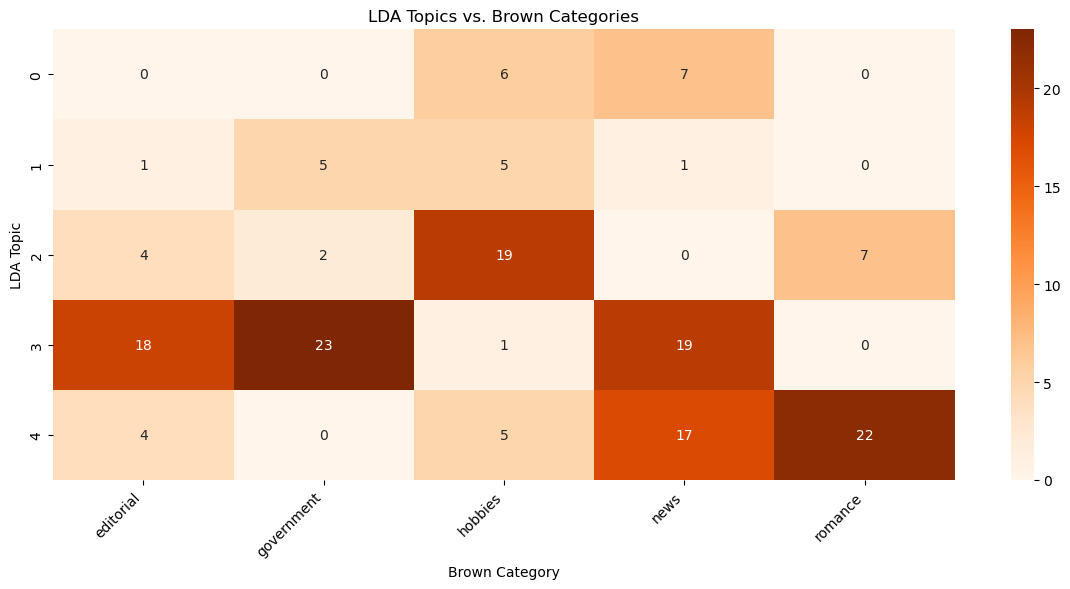

In [49]:
# Install missing libraries if needed
import nltk
nltk.download('stopwords')

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Set up stopwords and vectorizer
stop_words = stopwords.words('english')
count_text_vectorizer = CountVectorizer(stop_words=stop_words, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])

# Fit LDA model
lda_model = LDA(n_components=5, random_state=314)
lda_matrix = lda_model.fit_transform(count_text_vectors)

# Display top words per topic
def display_topics(model, feature_names, no_top_words=10):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        print(f"Topic {topic_idx + 1}: {', '.join(top_words)}\n")

display_topics(lda_model, count_text_vectorizer.get_feature_names_out())

# Assign dominant topic to each document
df['lda_topic'] = np.argmax(lda_matrix, axis=1)

# Compare topics with Brown categories
topic_vs_category = df.groupby(['lda_topic', 'category']).size().unstack(fill_value=0)
display(topic_vs_category)

# Optional: heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(topic_vs_category, annot=True, fmt='d', cmap='Oranges')
plt.title('LDA Topics vs. Brown Categories')
plt.ylabel('LDA Topic')
plt.xlabel('Brown Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [50]:
# Call `display_topics` on your fitted model here
display_topics(lda_model, count_text_vectorizer.get_feature_names_out())


Topic 1: game, last, home, clay, three, four, may, good, back, ball

Topic 2: may, service, medical, national, use, area, college, development, program, shelter

Topic 3: much, good, way, used, must, little, brown, house, water, may

Topic 4: state, states, united, government, may, president, 000, mr, general, tax

Topic 5: said, mrs, man, back, mr, old, last, day, home, john



Q: What inference do you draw from the displayed topics for your LDA model? 

A: The LDA topics show distinct themes. For example, Topic 1 includes terms like game, ball, and clay, suggesting a sports or leisure theme. Topic 4 includes government, states, and president, which clearly relates to politics. While some topics are tightly grouped around specific themes, others are more mixed, indicating some overlap in vocabulary across documents.

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: The LDA model shows a fairly strong alignment with the Brown categories. Topic 2 mostly maps to hobbies (19) and romance (7), while Topic 3 aligns well with government (23) and editorial (18). Topic 4 cleanly captures romance (22) and news (17). Overall, LDA does a good job identifying meaningful groupings, though some topics still overlap multiple categories.

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: The principal component scatterplot shows that the topics are fairly well-separated, indicating that the LDA model discovered distinct themes in the corpus. Each cluster represents a topic, and the spacing between them suggests good topic differentiation. The salient terms graph highlights the most distinguishing words for each topic—terms like game, president, and mrs stand out, helping to interpret what each topic is about. Together, these visualizations suggest that the model captured meaningful and interpretable topic structures.
